In [ ]:
# Clear all variables and reset the environment
%reset -f

**Prediction** involves using the regression model to compute fitted (predicted) values of the dependent variable, either within the sample, or for observatiins outside the sample. For example, suppose we want to predict gasoline prices using oil prices, we might use the regression model:
\begin{equation}
GasolinePrice_t = \beta_0 + \beta_1 OilPrice_t + \epsilon_t
\end{equation}
Below, we estimate the parameters of this model using monthly data, and get:
\begin{equation}
\widehat{GasolinePrice_t} = 0.167 + 0.025 \cdot OilPrice_t
\end{equation}
Prediction involves simply plugging oil prices of interest into the model. For example, we could do this with oil prices from our data, or more commonly with other oil prices of interest. For example, if an analyst predicts war in the Middle East will increase oil prices to \$150, we could plug that into the model to predict an associated gasoline price of \$3.98. A very common use of prediction is **scenario analysis**. This might include coming up with different oil price scenarios over which to predict gasoline prices.

We will also use the following regression model that does a better job accounting for inflation and potential changes in the relationship between oil and gas prices over time.
\begin{equation}
GasolinePrice_t = \alpha_0 + \alpha_1 OilPrice_t + \alpha_2 time_t + \alpha_3 OilPrice_t \cdot time_t + \eta_t
\end{equation}
where $time_t$ is a time trend variable.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

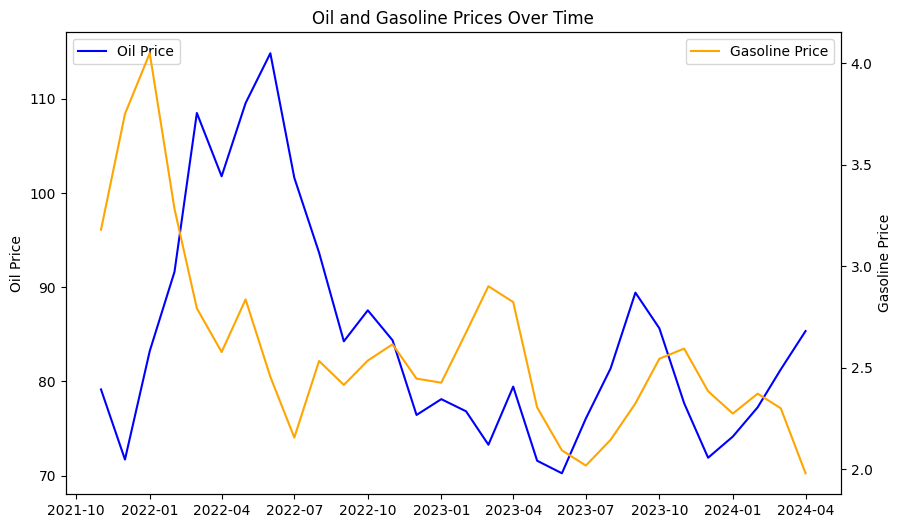

In [ ]:
# Load the data into a DataFrame
df = pd.read_csv('oil gasoline data.csv')

# Convert month column to datetime
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')

# Uncomment the line below to use only the most recent 30 observations - this makes the MoEs vary a lot.
df = df.tail(30)

# Set the month as the index for better plotting
df.set_index('Month', inplace=True)

# Plot both series with gasoline on a secondary axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['oil_price'], label='Oil Price', color='blue')
ax.set_ylabel('Oil Price')

# Create a secondary y-axis for gasoline price
ax2 = ax.twinx()
ax2.plot(df.index, df['gasoline_price'], label='Gasoline Price', color='orange')
ax2.set_ylabel('Gasoline Price')

# Add legends and title
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Oil and Gasoline Prices Over Time')
plt.show()


In [ ]:
# Assuming df is already loaded with the data and contains 'oil_price' and 'gasoline_price'
# Define Y as the gasoline_price
Y = df['gasoline_price'].values

# Define X with a column of ones (for intercept) and oil_price as the predictor
X_simple = np.column_stack((np.ones(len(df)), df['oil_price'].values))

# Calculate (X'X)^(-1) X'Y for the simple regression
beta_simple = np.linalg.inv(X_simple.T @ X_simple) @ X_simple.T @ Y

# Extract the intercept and slope
intercept_simple, slope_simple = beta_simple

# Display results from the simple regression
print("Simple Regression Results:")
print(f'Intercept: {intercept_simple}')
print(f'Slope (Oil Price): {slope_simple}')

# Define the oil price scenarios for prediction in simple regression
oil_prices = [60, 75, 90]
predicted_prices_simple = {price: intercept_simple + (slope_simple * price) for price in oil_prices}

# Display the predictions for each oil price scenario in simple regression
print("\nPredictions from Simple Regression:")
for price, prediction in predicted_prices_simple.items():
    print(f'Predicted Gasoline Price when Oil Price is ${price}: ${prediction:.2f}')

# ---- Multiple Regression with Time Trend and Interaction Term ----

# Step 1: Add a time trend variable `t`
df['t'] = np.arange(len(df))

# Define X with intercept, oil_price, t, and interaction term (t * oil_price)
X_multiple = np.column_stack((
    np.ones(len(df)),                # Intercept
    df['oil_price'].values,          # Oil price
    df['t'].values,                  # Time trend
    df['t'].values * df['oil_price'].values  # Interaction term: t * oil price
))

# Calculate (X'X)^(-1) X'Y for the multiple regression
beta_multiple = np.linalg.inv(X_multiple.T @ X_multiple) @ X_multiple.T @ Y

# Extract intercept and slopes for the multiple regression
intercept_multiple, slope_oil_price, slope_t, slope_interaction = beta_multiple

# Display results from the multiple regression
print("\nMultiple Regression Results:")
print(f'Intercept: {intercept_multiple}')
print(f'Slope (Oil Price): {slope_oil_price}')
print(f'Slope (Time Trend): {slope_t}')
print(f'Slope (Interaction t * Oil Price): {slope_interaction}')

# Predictions for the same oil price scenarios in multiple regression, using the last time point for `t`
t_last = df['t'].iloc[-1]
predicted_prices_multiple = {
    price: intercept_multiple + (slope_oil_price * price) + (slope_t * t_last) + (slope_interaction * t_last * price)
    for price in oil_prices
}

# Display the predictions for each oil price scenario in multiple regression
print("\nPredictions from Multiple Regression:")
for price, prediction in predicted_prices_multiple.items():
    print(f'Predicted Gasoline Price when Oil Price is ${price}: ${prediction:.2f}')



Simple Regression Results:
Intercept: 2.512094348186931
Slope (Oil Price): 0.0009614688783086049

Predictions from Simple Regression:
Predicted Gasoline Price when Oil Price is $60: $2.57
Predicted Gasoline Price when Oil Price is $75: $2.58
Predicted Gasoline Price when Oil Price is $90: $2.60

Multiple Regression Results:
Intercept: 4.972697916843618
Slope (Oil Price): -0.02044006942279128
Slope (Time Trend): -0.10342688524316693
Slope (Interaction t * Oil Price): 0.0007205962299345887

Predictions from Multiple Regression:
Predicted Gasoline Price when Oil Price is $60: $2.00
Predicted Gasoline Price when Oil Price is $75: $2.01
Predicted Gasoline Price when Oil Price is $90: $2.01


Of course, all of these predictions come with uncertainty, so in addition to point estimates, e.g., \$3.98, we often like to provide a confidence intercval or **prediction interval**. Suppose we are interested in predicting the dependent value $y^0$ which corresponds to the regressor vector $\mathbf{x}^0$. The actual value of $y^0$ is
\begin{equation}
y^0 = \mathbf{x}^0\mathbf{\beta} + \epsilon^0
\end{equation}
The prediction of $y^0$ is
\begin{equation}
\widehat{y}^0 = \mathbf{x}^0\mathbf{b}
\end{equation}
where $\mathbf{b}$ is the vector of estimated paramaters associated with the independent variables in $\mathbf{x}^0$. This is the minimum variance unbiased estimator of $E[y^0|\mathbf{x}^0] = \mathbf{x}^0\mathbf{\beta}$. The **prediction error** is
\begin{equation}
e^0 = \widehat{y}^0 - y^0 = (\mathbf{b} - \mathbf{\beta})'\mathbf{x}^0 - \epsilon^0.
\end{equation}
In order to provide a prediction interval, we need the **prediction variance** which can be expressed as
\begin{equation}
Var[e^0|\mathbf{X},\mathbf{x}^0] = \sigma^2 + Var[(\mathbf{b}-\mathbf{\beta})'\mathbf{x}^0|\mathbf{X},\mathbf{x}^0] = \sigma^2 + \mathbf{x}^{0'}[\sigma^2(\mathbf{X'X})^{-1}]\mathbf{x}^0
\end{equation}
In the case of simple linear regression with an intercept, the prediction variance simplifies to
\begin{equation}
Var[e^0|\mathbf{x},x^0] = \sigma^2 + \frac{\sigma^2}{n} + \sigma^2\frac{(x^0 - \bar{x})^2}{\sum_{i=1}^n(x_i - \bar{x})^2}.
\end{equation}
This latter formula helps us think about the different sources of uncertainty entering into prediction from regression. Once we have our prediction variance, we can get the precition interval for the $(1-\alpha)$\% confidence level, using
\begin{equation}
\widehat{y}^0 \pm t_{\alpha/2, n-k}\sqrt{Var[e^0|\mathbf{X},\mathbf{x}^0]}
\end{equation}
where $t_{\alpha/2, n-k}$ is the t critical value associated with $\alpha/2$ probability in the right tail of a Student's t distribution with $n-k$ degrees of freedom.

In [ ]:
# Sample size and number of parameters for each model
n = len(df)
k_simple = 2  # Intercept and oil price for simple regression
k_multiple = 4  # Intercept, oil price, time trend, interaction for multiple regression

# Define the list of oil prices for predictions
oil_prices = [50, 60, 75, 90, 200]

# ---- Simple Regression ----

# Define Y and X for simple regression
Y = df['gasoline_price'].values
X_simple = np.column_stack((np.ones(len(df)), df['oil_price'].values))

# Calculate (X'X)^(-1) X'Y for simple regression
beta_simple = np.linalg.inv(X_simple.T @ X_simple) @ X_simple.T @ Y
intercept_simple, slope_simple = beta_simple

# Calculate residuals and estimate sigma^2 for simple regression
y_hat_simple = X_simple @ beta_simple
residuals_simple = Y - y_hat_simple
sigma2_simple = np.sum(residuals_simple ** 2) / (n - k_simple)

# Calculate x-bar for oil price
x_bar = np.mean(df['oil_price'].values)

# Define a function for prediction variance in simple regression
def prediction_variance_simple(x0):
    return sigma2_simple * (1 + (1 / n) + ((x0 - x_bar) ** 2 / np.sum((df['oil_price'] - x_bar) ** 2)))

# Confidence level
alpha = 0.05
t_critical_simple = stats.t.ppf(1 - alpha / 2, n - k_simple)

# Predictions and intervals for simple regression
predicted_prices_simple_intervals = {}

for price in oil_prices:
    y_pred = intercept_simple + (slope_simple * price)
    pred_var = prediction_variance_simple(price)
    interval = t_critical_simple * np.sqrt(pred_var)
    moe = interval  # Margin of error is the interval value itself
    predicted_prices_simple_intervals[price] = (y_pred - interval, y_pred + interval, moe)
    print(f'Simple Regression Prediction for Oil Price ${price}: Interval=({y_pred - interval:.2f}, {y_pred + interval:.2f}), MOE={moe:.2f}')

# ---- Multiple Regression ----

# Add a time trend variable `t`
df['t'] = np.arange(len(df))

# Define X with intercept, oil_price, t, and interaction term (t * oil_price) for multiple regression
X_multiple = np.column_stack((
    np.ones(len(df)),                # Intercept
    df['oil_price'].values,          # Oil price
    df['t'].values,                  # Time trend
    df['t'].values * df['oil_price'].values  # Interaction term: t * oil price
))

# Calculate (X'X)^(-1) X'Y for multiple regression
beta_multiple = np.linalg.inv(X_multiple.T @ X_multiple) @ X_multiple.T @ Y
intercept_multiple, slope_oil_price, slope_t, slope_interaction = beta_multiple

# Calculate residuals and estimate sigma^2 for the multiple regression
y_hat_multiple = X_multiple @ beta_multiple
residuals_multiple = Y - y_hat_multiple
sigma2_multiple = np.sum(residuals_multiple ** 2) / (n - k_multiple)

# Define a function for prediction variance in multiple regression
def prediction_variance_multiple(x0, t0):
    x0_vector = np.array([1, x0, t0, t0 * x0])
    return sigma2_multiple * (1 + x0_vector @ np.linalg.inv(X_multiple.T @ X_multiple) @ x0_vector.T)

# Critical t-value for multiple regression
t_critical_multiple = stats.t.ppf(1 - alpha / 2, n - k_multiple)
t_last = df['t'].iloc[-1]  # Use the last time point in the dataset

# Predictions and intervals for multiple regression
predicted_prices_multiple_intervals = {}

for price in oil_prices:
    y_pred = (
        intercept_multiple + (slope_oil_price * price) +
        (slope_t * t_last) + (slope_interaction * t_last * price)
    )
    pred_var = prediction_variance_multiple(price, t_last)
    interval = t_critical_multiple * np.sqrt(pred_var)
    moe = interval  # Margin of error is the interval value itself
    predicted_prices_multiple_intervals[price] = (y_pred - interval, y_pred + interval, moe)
    print(f'Multiple Regression Prediction for Oil Price ${price}: Interval=({y_pred - interval:.2f}, {y_pred + interval:.2f}), MOE={moe:.2f}')


Simple Regression Prediction for Oil Price $50: Interval=(1.44, 3.69), MOE=1.13
Simple Regression Prediction for Oil Price $60: Interval=(1.51, 3.63), MOE=1.06
Simple Regression Prediction for Oil Price $75: Interval=(1.58, 3.59), MOE=1.01
Simple Regression Prediction for Oil Price $90: Interval=(1.60, 3.60), MOE=1.00
Simple Regression Prediction for Oil Price $200: Interval=(0.70, 4.71), MOE=2.01
Multiple Regression Prediction for Oil Price $50: Interval=(0.57, 3.42), MOE=1.42
Multiple Regression Prediction for Oil Price $60: Interval=(0.92, 3.08), MOE=1.08
Multiple Regression Prediction for Oil Price $75: Interval=(1.27, 2.74), MOE=0.74
Multiple Regression Prediction for Oil Price $90: Interval=(1.17, 2.86), MOE=0.84
Multiple Regression Prediction for Oil Price $200: Interval=(-3.05, 7.18), MOE=5.11
